In [3]:
# Dario Melconian
# Bryce Chevallier
!pip install featurewiz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached featurewiz-0.2.4-py3-none-any.whl (110 kB)
  Using cached pyarrow-7.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
  Using cached Pillow-9.4.0-cp39-cp39-manylinux_2_28_x86_64.whl (3.4 MB)
  Using cached category_encoders-2.6.0-py2.py3-none-any.whl (81 kB)
  Using cached jupyter-1.0.0-py2.py3-none-any.whl (2.7 kB)
  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)
  Using cached feather-format-0.4.1.tar.gz (3.2 kB)
  Preparing metadata (setup.py) ... done
  Using cached xlrd-2.0.1-py2.py3-none-any.whl (96 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 9.3 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt 
import featurewiz

# feature selection
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from featurewiz import featurewiz
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [130]:
# import the data
df = pd.read_csv("DataQuest Dataset - train_data.csv")
df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
0,1,10,2018,3,31,0,1,Meal Plan 1,0,Room_Type 1,1,0,Corporate,0,0,0,95.00,0,Canceled
1,2,116,2018,2,28,2,1,Meal Plan 1,0,Room_Type 1,1,0,Online,0,0,0,61.00,0,Canceled
2,3,11,2018,7,25,1,2,Meal Plan 1,0,Room_Type 1,2,1,Online,0,0,0,129.75,1,Not_Canceled
3,4,3,2017,9,12,0,1,Meal Plan 1,0,Room_Type 1,2,0,Online,0,0,0,152.00,3,Not_Canceled
4,5,28,2018,3,7,1,3,Meal Plan 1,0,Room_Type 1,2,0,Offline,0,0,0,87.00,0,Not_Canceled


In [131]:
df.shape

(29020, 19)

In [132]:
df = df.drop(df[df['MealPlan'] == 'Meal Plan 3'].index)
df.shape

(29015, 19)

In [133]:
table = pd.crosstab(df['RepeatedGuest'], df['BookingStatus'], margins = False)
table

BookingStatus,Canceled,Not_Canceled
RepeatedGuest,,
0,9505,18767
1,14,729


In [134]:
val = 14/(14+730)
print("about 1.8% of repeated guests have cancelled: ", val)

about 1.8% of repeated guests have cancelled:  0.01881720430107527


In [135]:
val = 9506/(9506+18770)
print("about 33.6% of non-repeated guests have cancelled: ", val)

about 33.6% of non-repeated guests have cancelled:  0.3361861649455368


In [136]:
# one-hot encode the categorical variables (4 of them, including response):
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [137]:
# Create an instance of the LabelEncoder class
encoder = LabelEncoder()

# Set the mapping between labels and encoded values
encoder.fit(['Not_Canceled', 'Canceled'])

# Encode the response variable using the specified mapping
df['BookingStatus'] = encoder.transform(df['BookingStatus'])

# Print the resulting DataFrame
df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
0,1,10,2018,3,31,0,1,Meal Plan 1,0,Room_Type 1,1,0,Corporate,0,0,0,95.00,0,0
1,2,116,2018,2,28,2,1,Meal Plan 1,0,Room_Type 1,1,0,Online,0,0,0,61.00,0,0
2,3,11,2018,7,25,1,2,Meal Plan 1,0,Room_Type 1,2,1,Online,0,0,0,129.75,1,1
3,4,3,2017,9,12,0,1,Meal Plan 1,0,Room_Type 1,2,0,Online,0,0,0,152.00,3,1
4,5,28,2018,3,7,1,3,Meal Plan 1,0,Room_Type 1,2,0,Offline,0,0,0,87.00,0,1


In [138]:
# replace 0 with 1 and vise-versa
df['BookingStatus'] = df['BookingStatus'].replace({0: 1, 1: 0})
df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
0,1,10,2018,3,31,0,1,Meal Plan 1,0,Room_Type 1,1,0,Corporate,0,0,0,95.00,0,1
1,2,116,2018,2,28,2,1,Meal Plan 1,0,Room_Type 1,1,0,Online,0,0,0,61.00,0,1
2,3,11,2018,7,25,1,2,Meal Plan 1,0,Room_Type 1,2,1,Online,0,0,0,129.75,1,0
3,4,3,2017,9,12,0,1,Meal Plan 1,0,Room_Type 1,2,0,Online,0,0,0,152.00,3,0
4,5,28,2018,3,7,1,3,Meal Plan 1,0,Room_Type 1,2,0,Offline,0,0,0,87.00,0,0


In [139]:
df.isna().sum()
#df.iloc[29017]

BookingID                  0
LeadTime                   0
ArrivalYear                0
ArrivalMonth               0
ArrivalDate                0
NumWeekendNights           0
NumWeekNights              0
MealPlan                   0
Parking                    0
RoomType                   0
NumAdults                  0
NumChildren                0
MarketSegment              0
RepeatedGuest              0
NumPrevCancellations       0
NumPreviousNonCancelled    0
AvgRoomPrice               0
SpecialRequests            0
BookingStatus              0
dtype: int64

In [140]:
# Create an instance of the OneHotEncoder class
encoder = OneHotEncoder()

cat_vars = ['MealPlan', 'MarketSegment']

# Specify which columns to encode and fit the encoder to the data
encoder.fit(df[cat_vars])

encoded_vars = encoder.transform(df[cat_vars]).toarray()

encoded = pd.DataFrame(encoded_vars,columns=encoder.get_feature_names_out(cat_vars))

# fix the indices
df = df.reset_index(drop=True)
encoded = encoded.reset_index(drop=True)
df = pd.concat([df, encoded], axis =1)

print(df.shape)

(29015, 27)


In [141]:
df.head()
df.shape

(29015, 27)

In [142]:
df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,...,SpecialRequests,BookingStatus,MealPlan_Meal Plan 1,MealPlan_Meal Plan 2,MealPlan_Not Selected,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Offline,MarketSegment_Online
0,1,10,2018,3,31,0,1,Meal Plan 1,0,Room_Type 1,...,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,116,2018,2,28,2,1,Meal Plan 1,0,Room_Type 1,...,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,11,2018,7,25,1,2,Meal Plan 1,0,Room_Type 1,...,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,3,2017,9,12,0,1,Meal Plan 1,0,Room_Type 1,...,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,28,2018,3,7,1,3,Meal Plan 1,0,Room_Type 1,...,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [108]:
df.columns

Index(['LeadTime', 'ArrivalYear', 'ArrivalMonth', 'ArrivalDate',
       'NumWeekendNights', 'NumWeekNights', 'Parking', 'NumAdults',
       'NumChildren', 'MarketSegment', 'RepeatedGuest', 'NumPrevCancellations',
       'NumPreviousNonCancelled', 'AvgRoomPrice', 'SpecialRequests',
       'BookingStatus', 'MealPlan_Meal Plan 1', 'MealPlan_Meal Plan 2',
       'MealPlan_Not Selected', 'MarketSegment_Aviation',
       'MarketSegment_Complementary', 'MarketSegment_Corporate',
       'MarketSegment_Offline', 'MarketSegment_Online'],
      dtype='object')

In [143]:
df = df.drop('BookingID', axis=1)

In [144]:
df = df.drop('MealPlan', axis=1)
df = df.drop('RoomType', axis=1)

In [145]:
df = df.drop('MarketSegment', axis=1)

In [146]:
X = df.drop(['BookingStatus'],axis=1)
#X = pd.DataFrame(df.data, columns=df.feature_names)

y = df.BookingStatus.values 

In [147]:
# not going to scale the X's right now, can look into this later if we need to improve model
X_scaled =  StandardScaler().fit_transform(X) 

In [148]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size = 0.2,stratify=y, random_state=1)

In [149]:
classifier = RandomForestClassifier()
 
classifier.fit(X_train,y_train)

RandomForestClassifier()

In [150]:
# make prediction 
preds = classifier.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid)

0.9016026193348268

0.90 great accuracy.

In [151]:
from sklearn.inspection import permutation_importance
classifier.feature_importances_

array([0.31592495, 0.02604356, 0.08256918, 0.09667396, 0.03792439,
       0.05457997, 0.00710261, 0.02450094, 0.00836603, 0.00257739,
       0.00036916, 0.00171058, 0.16516773, 0.10159303, 0.00760125,
       0.00783943, 0.00615577, 0.00057721, 0.00059436, 0.00446673,
       0.01879139, 0.02887037])

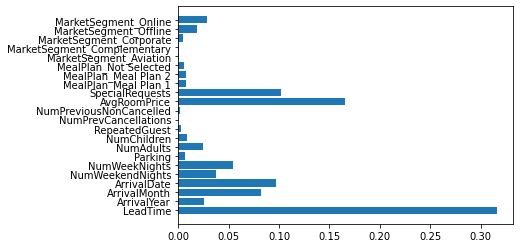

In [152]:
feature_names = X.columns
sorted_idx = classifier.feature_importances_.argsort()

plt.barh(feature_names, classifier.feature_importances_)
#plt.figure(figsize= (6000,9000))
plt.savefig('FeatureSelection.png', dpi=300)
plt.show()

#importances = classifier.feature_importances_
#print(importances)

In [154]:
# Apply the model to the test set.
rf_pred_class_test = classifier.predict(X_valid)
rf_probs_test = classifier.predict_proba(X_valid)

In [156]:
# Get the predicted probabilities for each class
probs = classifier.predict_proba(X_valid)

# Apply a custom threshold to the probabilities (we played around with this)
threshold = 0.44
rf_pred_class_test = (probs[:, 1] > threshold).astype(int)

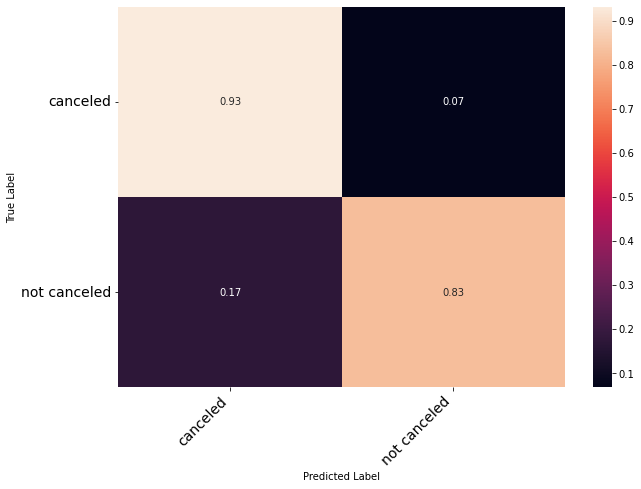

In [157]:
# Calculate confusion matrix
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

confusion_matrix_rf = confusion_matrix(y_true = y_valid, 
                    y_pred = rf_pred_class_test)

# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_rf, index=['canceled', 'not canceled'], columns=['canceled', 'not canceled'], 
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, 
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# show plot
plt.show()

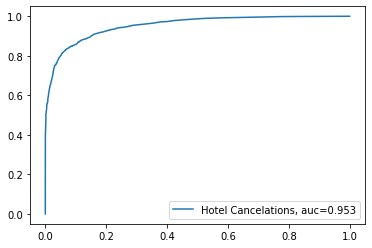

In [159]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_valid, rf_probs_test[:,1])

# Save the AUC in a variable to show it 
auc = np.round(roc_auc_score(y_true = y_valid, 
                             y_score = rf_probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Hotel Cancelations, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [165]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [167]:
# Get the predicted probabilities for each class
probs = classifier.predict_proba(X_valid)

# Apply a custom threshold to the probabilities
threshold = 0.53
y_pred = (probs[:, 1] > threshold).astype(int)

In [168]:
# calculate precision, recall, and F1 score
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

# print the results
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

Precision: 0.8929
Recall: 0.7925
F1 Score: 0.8397


### Great scores.

In [117]:
from xgboost import XGBClassifier

In [118]:
classifier2 = XGBClassifier()

classifier2.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [119]:
# make prediction 
preds = classifier2.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid)

0.8883336205410994

# AutoML Feature Selection

In [95]:
!pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
featurewiz has selected 0.7 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (29015, 23)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sampl

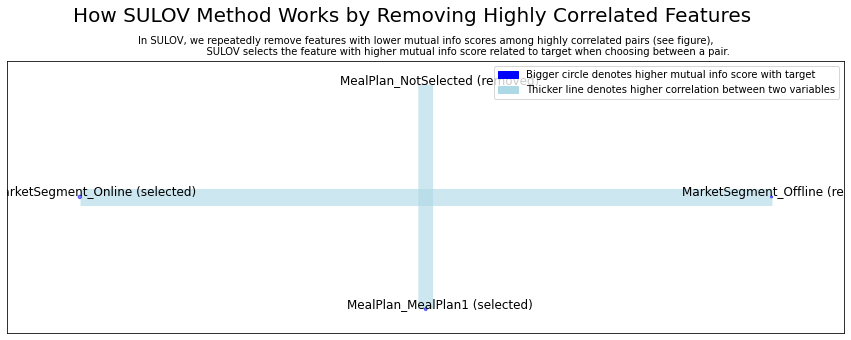

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 20
Final list of selected 20 vars after SULOV = ['ArrivalDate', 'ArrivalMonth', 'ArrivalYear', 'AvgRoomPrice', 'LeadTime', 'MarketSegment_Aviation', 'MarketSegment_Complementary', 'MarketSegment_Corporate', 'MealPlan_MealPlan2', 'NumAdults', 'NumChildren', 'NumPrevCancellations', 'NumPreviousNonCancelled', 'NumWeekNights', 'NumWeekendNights', 'Parking', 'RepeatedGuest', 'SpecialRequests', 'MarketSegment_Online', 'MealPlan_MealPlan1']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 20 
    Taking top 5 features per iteration.

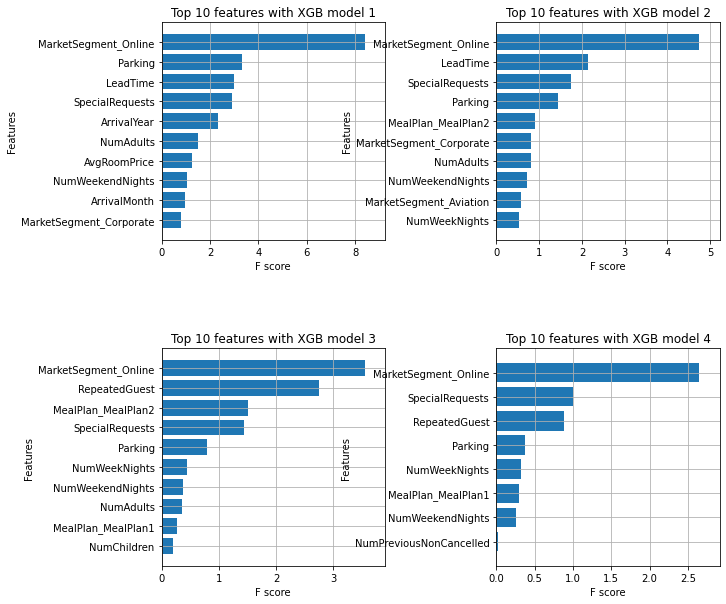

    Completed XGBoost feature selection in 1 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 6 important features:
['MarketSegment_Online', 'Parking', 'LeadTime', 'SpecialRequests', 'RepeatedGuest', 'MealPlan_MealPlan2']
Total Time taken for featurewiz selection = 2 seconds
Output contains a list of 6 important features and a train dataframe


In [120]:
# automatic feature selection by using featurewiz package
target = 'BookingStatus'

features, train = featurewiz(df, target, corr_limit=0.7, verbose=2, sep=",", header=0,test_data="", feature_engg="", category_encoders="")

In [121]:
print(features)

['MarketSegment_Online', 'Parking', 'LeadTime', 'SpecialRequests', 'RepeatedGuest', 'MealPlan_Meal Plan 2']


In [122]:
#split data into feature and target
X_new = train.drop(['BookingStatus'],axis=1)

y = train.BookingStatus.values 

In [123]:
# preprocessing the features 
X_scaled =  StandardScaler().fit_transform(X_new)

In [124]:
#split data into train and validate 
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size = 0.2,stratify=y, random_state=1)

In [125]:
# create and train classifier 
classifier_auto = RandomForestClassifier()
 
classifier_auto.fit(X_train,y_train)

RandomForestClassifier()

In [126]:
# make prediction 
preds = classifier_auto.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid) 

0.8244011718076857

In [127]:
classifier2_auto = XGBClassifier()

classifier2_auto.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [128]:
# make prediction 
preds = classifier2_auto.predict(X_valid) 
# check performance
accuracy_score(preds,y_valid)

0.829226262278132

Accuracy worse using AutoML via featurewiz package.